In [7]:
# load data
import pandas as pd
from preprocess import get_maneuvers

data = pd.read_csv('data/preprocessed/41335.csv', parse_dates=['EPOCH'])
maneuvers = get_maneuvers('41335')
maneuvers = [i for i in maneuvers if i > data['EPOCH'][0]]

print(data.head())

                       EPOCH  ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  \
0 2020-01-01 04:30:19.085760      0.000088      98.6311         70.3299   
1 2020-01-01 11:14:15.999072      0.000088      98.6311         70.6066   
2 2020-01-01 19:39:12.139200      0.000088      98.6310         70.9524   
3 2020-01-01 21:20:11.367744      0.000087      98.6310         71.0215   
4 2020-01-02 04:04:08.279328      0.000087      98.6310         71.2982   

   ARG_OF_PERICENTER  MEAN_ANOMALY  SEMIMAJOR_AXIS  MANEUVERED  
0            88.0443      272.0839        7180.802           0  
1            88.4851      271.6430        7180.802           0  
2            88.3910      271.7371        7180.802           0  
3            88.4149      271.7132        7180.802           0  
4            88.6427      271.4853        7180.802           0  


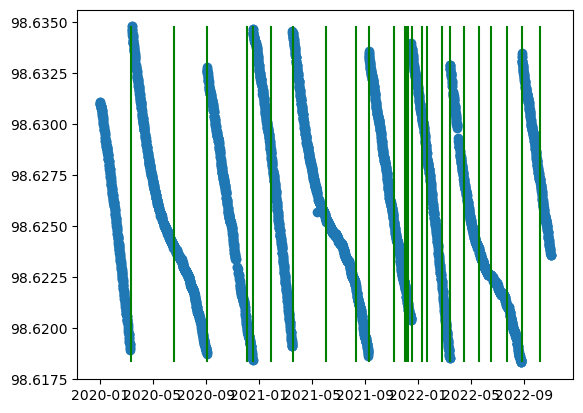

In [23]:
# plot each feature with timestamps of maneuvers marked
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = data['EPOCH']
y = data['INCLINATION']
ax.scatter(x, y)
ax.vlines(maneuvers, y.min(), y.max(), color='g')

plt.show()